In [1]:
from pykinect2 import PyKinectRuntime
from pykinect2 import PyKinectV2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import sys
import cv2
import glob
# directory reach
import pyrealsense2 as rs
import pickle

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from support.ar_calculations import calculate_rotmat
from support.detect_lframe import detect_lframe_from_img
from support.pymf import get_MF_devices as get_camera_list

kinectColor = PyKinectRuntime.PyKinectRuntime(PyKinectV2.FrameSourceTypes_Color)
_folder_name = "calibration3"

In [2]:
def calculate_rotmat_from_3markers(corners, ids, camera_matrix, dist_coeffs, marker_length = 0.05):

    rotation_vector, translation_vector, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, camera_matrix, dist_coeffs)

    ids = list(ids)

    z_inx = ids.index(6)
    org_inx = ids.index(9)
    x_inx = ids.index(10)
    print(z_inx, org_inx, x_inx)

    zvec = translation_vector[z_inx][0]
    zvec = np.reshape(zvec, (3, 1))
    org = translation_vector[org_inx][0] 
    org = np.reshape(org, (3, 1))
    xvec = translation_vector[x_inx][0]
    xvec = np.reshape(xvec, (3, 1))


    translation_vector
    zvec
    rotMat = calculate_rotmat(xvec, zvec, org)
    rotMat

    t_xvec = zvec - org 

    translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1) # adding the corrections in the new L frame

    rotMat.T@t_xvec + translation_correction
    print(t_xvec)
    
    print(rotMat.T@t_xvec)
    return rotMat, org

In [3]:
"""pth to calibration files"""
_pth = os.path.join(os.path.dirname(os.getcwd()), "test_programs", "test_data",_folder_name)
_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\skateboard_gui\\test_programs\\test_data\\calibration3'

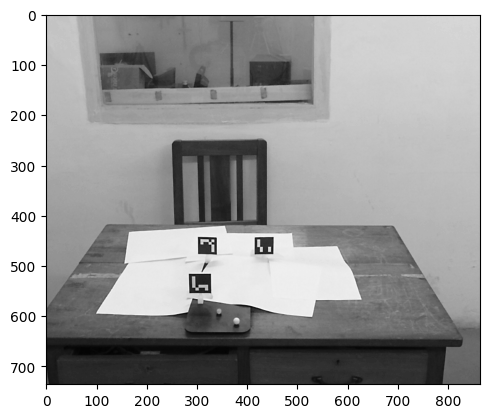

In [4]:
"""kinect frame capture"""
yPos = 112
xPos = 274

yRes = 736
xRes = 864
scalling = 2
yRes

while True:
    if kinectColor.has_new_color_frame:
        color_frame = kinectColor.get_last_color_frame()
        color_frame = np.reshape(color_frame, (1080, 1920, 4))
        color_frame = cv2.flip(color_frame, 1)
        color_frame = color_frame[yPos * scalling:yPos * scalling + yRes,
                         xPos * scalling:xPos * scalling + xRes].copy()
        gray_kinect = cv2.cvtColor(color_frame, cv2.COLOR_BGRA2GRAY)
        # if not np.all(color_frame):
        break
plt.imshow(gray_kinect, cmap="gray")
# print(color_frame)

In [5]:
"""for kinect calculating rotmat"""
corners, ids, _ = detect_lframe_from_img(gray_kinect)
_kinect_calib_file = os.path.join(_pth, "kinect_calibration.msgpack")
with open(_kinect_calib_file, "rb") as f:
    kinect_calib = mp.load(f, object_hook=mpn.decode)
    k_camera_matrix = kinect_calib[0]
    k_dist_coeffs = kinect_calib[1]
        
k_rotmat, k_org = calculate_rotmat_from_3markers(corners, ids, marker_length=0.05, camera_matrix=k_camera_matrix, dist_coeffs=k_dist_coeffs)

#save to path
_kinect_rotmat_file = os.path.join(_pth, "kinect_rotmat.msgpack")
with open(_kinect_rotmat_file, "wb") as f:
    _rt_packed = mp.packb(k_rotmat, default=mpn.encode)
    _org_packed = mp.packb(k_org, default=mpn.encode)
    f.write(_rt_packed)
    f.write(_org_packed)
    f.close()


0 2 1
[[ 0.01178014]
 [ 0.06448056]
 [-0.19232277]]
[[-0.00517389]
 [ 0.        ]
 [ 0.20312015]]


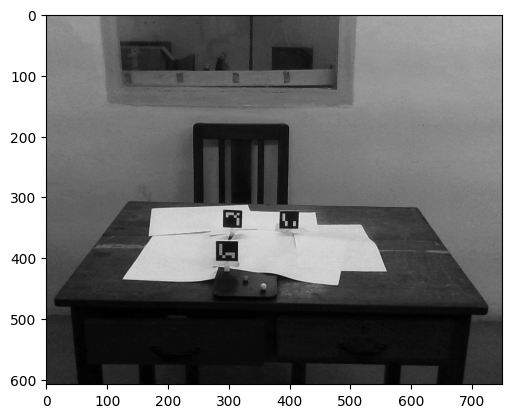

In [8]:
"""realsense frame capture"""

yResRs = 670
xResRs = 750

# Configure depth and color streams

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8 , 15)
# config.auto_exposure_priority = True
pipeline.start(config)

while True:
    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    color_image = np.asanyarray(color_frame.get_data())
    color_image = color_image[yPos:yPos + yResRs, xPos:xPos + xResRs].copy()
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    break
plt.imshow(gray_image, cmap="gray")


In [9]:
"""for realsense calculating rotmat"""
corners, ids, _ = detect_lframe_from_img(gray_image)
_rs_calib_file = os.path.join(_pth, "realsense_calibration.msgpack")
with open(_rs_calib_file, "rb") as f:
    rs_calib = mp.load(f, object_hook=mpn.decode)
    rs_camera_matrix = rs_calib[0]
    rs_dist_coeffs = rs_calib[1]

r_rotmat, r_org = calculate_rotmat_from_3markers(corners, ids, marker_length=0.05, camera_matrix=rs_camera_matrix, dist_coeffs=rs_dist_coeffs)

#save to path
_rs_rotmat_file = os.path.join(_pth, "realsense_rotmat.msgpack")
with open(_rs_rotmat_file, "wb") as f:
    _rt_packed = mp.packb(r_rotmat, default=mpn.encode)
    _org_packed = mp.packb(r_org, default=mpn.encode)
    f.write(_rt_packed)
    f.write(_org_packed)
    f.close()

0 2 1
[[ 0.00646876]
 [ 0.06957128]
 [-0.21636835]]
[[-0.00100209]
 [ 0.        ]
 [ 0.22736813]]


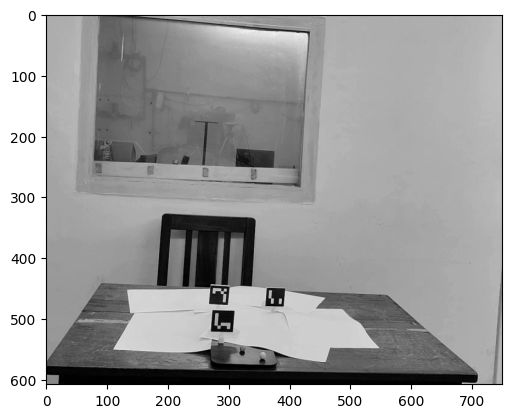

In [20]:
"""webcam frame capture"""

#list available webcam

device_list = get_camera_list()
webcam_id = device_list.index("e2eSoft iVCam")

cap = cv2.VideoCapture(webcam_id)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 15)

while True:
    ret, frame = cap.read()
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.flip(gray_image, 1)
    gray_image = gray_image[yPos:yPos + yResRs, xPos:xPos + xResRs].copy()
    break

cap.release()

plt.imshow(gray_image, cmap='gray')


In [21]:
"""for webcam calculating rotmat"""
_webcam_calib_file = os.path.join(_pth, "webcam_calibration.msgpack")
corners, ids, _ = detect_lframe_from_img(gray_image)
with open(_webcam_calib_file, "rb") as f:
    webcam_calib = mp.load(f, object_hook=mpn.decode)
    w_camera_matrix = webcam_calib[0]
    w_dist_coeffs = webcam_calib[1]

w_rotmat, w_org = calculate_rotmat_from_3markers(corners, ids, marker_length=0.05, camera_matrix=w_camera_matrix, dist_coeffs=w_dist_coeffs)


#save to path
_webcam_rotmat_file = os.path.join(_pth, "webcam_rotmat.msgpack")
with open(_webcam_rotmat_file, "wb") as f:
    _rt_packed = mp.packb(w_rotmat, default=mpn.encode)
    _org_packed = mp.packb(w_org, default=mpn.encode)
    f.write(_rt_packed)
    f.write(_org_packed)
    f.close()

0 2 1
[[ 0.03051843]
 [ 0.01519965]
 [-0.21361043]]
[[1.84032506e-02]
 [1.73472348e-18]
 [2.15529905e-01]]


In [ ]:
"""closing cameras"""

kinectColor.close()